In [1]:
# * * * * * * * * * * * * * * * *
# Configuration
# * * * * * * * * * * * * * * * *
EXPERIMENT_NUM='25'

DATASET_DIR = '/workspace/datasets'
OUTPUT_DIR = '/workspace/outputs/profiles-v1/profiles-v1-pca'

DEVICE = "cpu"

LATENT_DIM=4
BATCH_SIZE=200
EPOCHS=100
BETA=0.2
LEARNING_RATE=1e-3
GAMMA=0.1

INPUT_DIM=(1,120)

In [2]:
import os
from sklearn.preprocessing import StandardScaler
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
from torchinfo import summary

from lunar_vae import VAE, train, SampleLatentSpace, VisualizeLatentSpace
from utils import (
    CollectStatisticsFromProfilesV2,
    GenerateDensityPlot,
    GetDataMetrics,
    GetMeanLatentValues,
    LoadProfileList,
    LoadTemperatureDataV2, 
    PlotHistograms,
    PlotLosses,
    PrintAndLog,
    SaveLossesToCSV,
    SetupOutputDir,
    SplitAndNormalizeData,
)

# * * * * * * * * * * * * * * * *
# Setting Variables
# * * * * * * * * * * * * * * * *
INPUT_PT_PATH = f"/workspace/datasets/profiles-v1/profiles-v1-pca/profiles-v1-pca-5-sample-{EXPERIMENT_NUM}.pt"
LABEL = f'profiles_v1_pca_{EXPERIMENT_NUM}'

# * * * * * * * * * * * * * * * *
# Make Directory
# * * * * * * * * * * * * * * * *
model_dir = SetupOutputDir(OUTPUT_DIR, parent_folder=LABEL, sub_folders=["reconstruction_images"])
print(f"Created directory {model_dir}")

Created directory /workspace/outputs/profiles-v1/profiles-v1-pca/profiles_v1_pca_25_20250721_0015


In [3]:
# * * * * * * * * * * * * * * * *
# Load Temp Data
# * * * * * * * * * * * * * * * *
temp_data = torch.load(INPUT_PT_PATH)

Saved figure to /workspace/outputs/profiles-v1/profiles-v1-pca/profiles_v1_pca_25_20250721_0015/density_plot.png


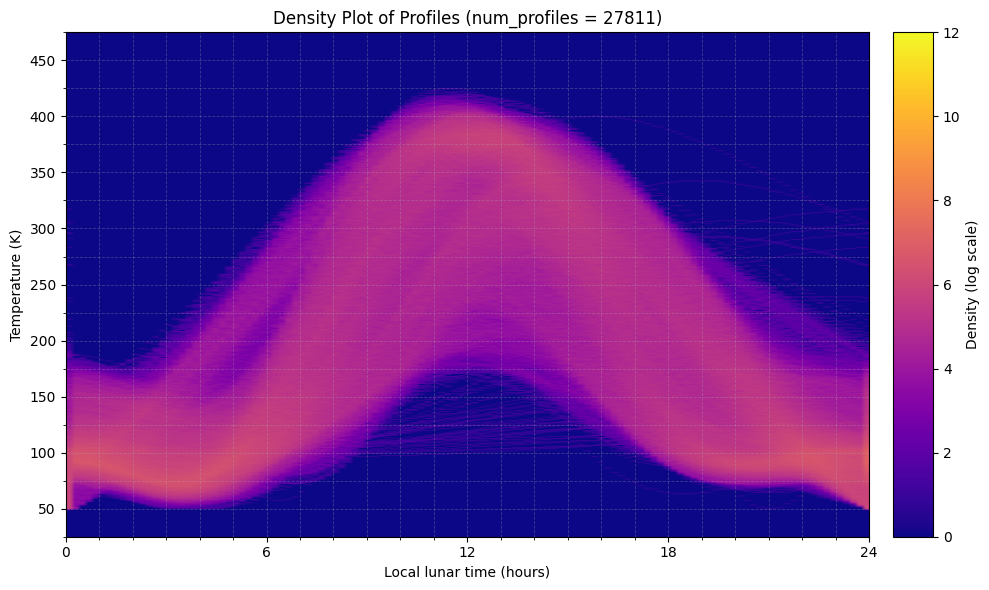

In [4]:
# * * * * * * * * * * * * * * * *
# Generate Density Plot
# * * * * * * * * * * * * * * * *
GenerateDensityPlot(temp_data, model_dir)

In [5]:
# * * * * * * * * * * * * * * * *
# Training Log
# * * * * * * * * * * * * * * * 
log_filepath = os.path.join(model_dir, 'training.log')

# * * * * * * * * * * * * * * * *
# Data Prep
# * * * * * * * * * * * * * * * *
x_data_mean, x_data_std, x_data_min, x_data_max = GetDataMetrics(temp_data)

PrintAndLog(log_filepath, "Data Metrics:\n")
PrintAndLog(log_filepath, f"\tMean: {x_data_mean:.4f}\n")
PrintAndLog(log_filepath, f"\tSTD: {x_data_std:.4f}\n")
PrintAndLog(log_filepath, f"\tMin Temp: {x_data_min:.4f}\n")
PrintAndLog(log_filepath, f"\tMax Temp: {x_data_max:.4f}\n")

# Normalize Data (Mean=0, STD=1)
scaler = StandardScaler()
train_loader, val_loader, test_loader = SplitAndNormalizeData(
	temp_data, scaler, BATCH_SIZE, DEVICE)

PrintAndLog(log_filepath, "Datasets:\n")
PrintAndLog(
	log_filepath,
	f"\tTraining Data: {len(train_loader.dataset)}\n")
PrintAndLog(
	log_filepath,
	f"\tValidation Data: {len(val_loader.dataset)}\n")
PrintAndLog(log_filepath, f"\tTest Data: {len(test_loader.dataset)}\n")

Data Metrics:
Mean: 190.0866
STD: 96.2880
Min Temp: 50.0020
Max Temp: 424.8680
Datasets:
Training Data: 19467
Validation Data: 5562
Test Data: 2782


In [6]:
# * * * * * * * * * * * * * * * *
# VAE Setup
# * * * * * * * * * * * * * * * *
vae = VAE(latent_dim=LATENT_DIM).to(DEVICE)
optimizer = optim.Adam(vae.parameters(), lr=LEARNING_RATE, weight_decay=0)
scheduler = ExponentialLR(optimizer, gamma=GAMMA)

summary(vae, input_size=(BATCH_SIZE, INPUT_DIM[0], INPUT_DIM[1]))

Layer (type:depth-idx)                   Output Shape              Param #
VAE                                      [200, 1, 120]             --
├─Encoder: 1-1                           [200, 4, 1]               --
│    └─Wrap1d: 2-1                       [200, 1, 122]             --
│    └─ConstantPad1d: 2-2                [200, 1, 128]             --
│    └─Conv1d: 2-3                       [200, 32, 128]            128
│    └─BatchNorm1d: 2-4                  [200, 32, 128]            64
│    └─Conv1d: 2-5                       [200, 32, 64]             2,080
│    └─BatchNorm1d: 2-6                  [200, 32, 64]             64
│    └─Conv1d: 2-7                       [200, 32, 32]             2,080
│    └─BatchNorm1d: 2-8                  [200, 32, 32]             64
│    └─Conv1d: 2-9                       [200, 32, 16]             2,080
│    └─BatchNorm1d: 2-10                 [200, 32, 16]             64
│    └─Conv1d: 2-11                      [200, 32, 8]              2,080
│ 

[Training] Epoch 1/100: 100%|██████████| 98/98 [00:03<00:00, 28.75it/s, best_loss=0.7066]


[Training] Epoch 1/100, L1 Loss: 0.7157, L2 Loss: 0.7661, KL Loss: 0.3633, LR: 0.001000


[Validation] Epoch 1/100: 100%|██████████| 28/28 [00:00<00:00, 104.90it/s]


[Validation] Epoch 1/100, Val L1 Loss: 0.6118, Val L2 Loss: 0.5868, Val KL Loss: 0.5600
[Validation] Saved checkpoint in '/workspace/outputs/profiles-v1/profiles-v1-pca/profiles_v1_pca_25_20250721_0015'


[Training] Epoch 2/100: 100%|██████████| 98/98 [00:03<00:00, 29.37it/s, best_loss=0.6355]


[Training] Epoch 2/100, L1 Loss: 0.6371, L2 Loss: 0.6287, KL Loss: 0.4984, LR: 0.000100


[Validation] Epoch 2/100: 100%|██████████| 28/28 [00:00<00:00, 99.72it/s]


[Validation] Epoch 2/100, Val L1 Loss: 0.6044, Val L2 Loss: 0.5771, Val KL Loss: 0.5163
[Validation] Saved checkpoint in '/workspace/outputs/profiles-v1/profiles-v1-pca/profiles_v1_pca_25_20250721_0015'


[Training] Epoch 3/100: 100%|██████████| 98/98 [00:03<00:00, 29.78it/s, best_loss=0.6610]


[Training] Epoch 3/100, L1 Loss: 0.6305, L2 Loss: 0.6194, KL Loss: 0.5074, LR: 0.000010


[Validation] Epoch 3/100: 100%|██████████| 28/28 [00:00<00:00, 100.92it/s]


[Validation] Epoch 3/100, Val L1 Loss: 0.6090, Val L2 Loss: 0.5806, Val KL Loss: 0.4983


[Training] Epoch 4/100: 100%|██████████| 98/98 [00:03<00:00, 29.29it/s, best_loss=0.6097]


[Training] Epoch 4/100, L1 Loss: 0.6304, L2 Loss: 0.6200, KL Loss: 0.5082, LR: 0.000001


[Validation] Epoch 4/100: 100%|██████████| 28/28 [00:00<00:00, 102.40it/s]


[Validation] Epoch 4/100, Val L1 Loss: 0.6033, Val L2 Loss: 0.5750, Val KL Loss: 0.5119
[Validation] Saved checkpoint in '/workspace/outputs/profiles-v1/profiles-v1-pca/profiles_v1_pca_25_20250721_0015'


[Training] Epoch 5/100: 100%|██████████| 98/98 [00:03<00:00, 28.57it/s, best_loss=0.6576]


[Training] Epoch 5/100, L1 Loss: 0.6308, L2 Loss: 0.6200, KL Loss: 0.5081, LR: 0.000000


[Validation] Epoch 5/100: 100%|██████████| 28/28 [00:00<00:00, 98.98it/s]


[Validation] Epoch 5/100, Val L1 Loss: 0.6042, Val L2 Loss: 0.5760, Val KL Loss: 0.5053


[Training] Epoch 6/100: 100%|██████████| 98/98 [00:03<00:00, 29.35it/s, best_loss=0.6507]


[Training] Epoch 6/100, L1 Loss: 0.6303, L2 Loss: 0.6195, KL Loss: 0.5079, LR: 0.000000


[Validation] Epoch 6/100: 100%|██████████| 28/28 [00:00<00:00, 98.26it/s]


[Validation] Epoch 6/100, Val L1 Loss: 0.6021, Val L2 Loss: 0.5738, Val KL Loss: 0.5056
[Validation] Saved checkpoint in '/workspace/outputs/profiles-v1/profiles-v1-pca/profiles_v1_pca_25_20250721_0015'


[Training] Epoch 7/100: 100%|██████████| 98/98 [00:03<00:00, 28.90it/s, best_loss=0.6248]


[Training] Epoch 7/100, L1 Loss: 0.6312, L2 Loss: 0.6206, KL Loss: 0.5082, LR: 0.000000


[Validation] Epoch 7/100: 100%|██████████| 28/28 [00:00<00:00, 101.71it/s]


[Validation] Epoch 7/100, Val L1 Loss: 0.6017, Val L2 Loss: 0.5732, Val KL Loss: 0.5035
[Validation] Saved checkpoint in '/workspace/outputs/profiles-v1/profiles-v1-pca/profiles_v1_pca_25_20250721_0015'


[Training] Epoch 8/100: 100%|██████████| 98/98 [00:03<00:00, 29.03it/s, best_loss=0.6546]


[Training] Epoch 8/100, L1 Loss: 0.6304, L2 Loss: 0.6196, KL Loss: 0.5079, LR: 0.000000


[Validation] Epoch 8/100: 100%|██████████| 28/28 [00:00<00:00, 96.44it/s]


[Validation] Epoch 8/100, Val L1 Loss: 0.6042, Val L2 Loss: 0.5759, Val KL Loss: 0.5096


[Training] Epoch 9/100: 100%|██████████| 98/98 [00:03<00:00, 29.22it/s, best_loss=0.6284]


[Training] Epoch 9/100, L1 Loss: 0.6302, L2 Loss: 0.6186, KL Loss: 0.5082, LR: 0.000000


[Validation] Epoch 9/100: 100%|██████████| 28/28 [00:00<00:00, 100.03it/s]


[Validation] Epoch 9/100, Val L1 Loss: 0.6060, Val L2 Loss: 0.5778, Val KL Loss: 0.5045


[Training] Epoch 10/100: 100%|██████████| 98/98 [00:03<00:00, 29.03it/s, best_loss=0.6449]


[Training] Epoch 10/100, L1 Loss: 0.6315, L2 Loss: 0.6211, KL Loss: 0.5080, LR: 0.000000


[Validation] Epoch 10/100: 100%|██████████| 28/28 [00:00<00:00, 105.65it/s]


[Validation] Epoch 10/100, Val L1 Loss: 0.6047, Val L2 Loss: 0.5766, Val KL Loss: 0.4998


[Training] Epoch 11/100: 100%|██████████| 98/98 [00:03<00:00, 29.23it/s, best_loss=0.6328]


[Training] Epoch 11/100, L1 Loss: 0.6306, L2 Loss: 0.6195, KL Loss: 0.5081, LR: 0.000000


[Validation] Epoch 11/100: 100%|██████████| 28/28 [00:00<00:00, 88.90it/s]


[Validation] Epoch 11/100, Val L1 Loss: 0.6050, Val L2 Loss: 0.5771, Val KL Loss: 0.4991


[Training] Epoch 12/100: 100%|██████████| 98/98 [00:03<00:00, 28.71it/s, best_loss=0.6320]


[Training] Epoch 12/100, L1 Loss: 0.6310, L2 Loss: 0.6206, KL Loss: 0.5081, LR: 0.000000


[Validation] Epoch 12/100: 100%|██████████| 28/28 [00:00<00:00, 87.32it/s]


[Validation] Epoch 12/100, Val L1 Loss: 0.6031, Val L2 Loss: 0.5744, Val KL Loss: 0.5131


[Training] Epoch 13/100: 100%|██████████| 98/98 [00:03<00:00, 28.44it/s, best_loss=0.6474]


[Training] Epoch 13/100, L1 Loss: 0.6299, L2 Loss: 0.6188, KL Loss: 0.5084, LR: 0.000000


[Validation] Epoch 13/100: 100%|██████████| 28/28 [00:00<00:00, 96.94it/s]


[Validation] Epoch 13/100, Val L1 Loss: 0.6008, Val L2 Loss: 0.5728, Val KL Loss: 0.5089
[Validation] Saved checkpoint in '/workspace/outputs/profiles-v1/profiles-v1-pca/profiles_v1_pca_25_20250721_0015'


[Training] Epoch 14/100: 100%|██████████| 98/98 [00:03<00:00, 28.62it/s, best_loss=0.6603]


[Training] Epoch 14/100, L1 Loss: 0.6308, L2 Loss: 0.6200, KL Loss: 0.5082, LR: 0.000000


[Validation] Epoch 14/100: 100%|██████████| 28/28 [00:00<00:00, 97.24it/s]


[Validation] Epoch 14/100, Val L1 Loss: 0.6032, Val L2 Loss: 0.5749, Val KL Loss: 0.5030


[Training] Epoch 15/100: 100%|██████████| 98/98 [00:03<00:00, 27.45it/s, best_loss=0.6460]


[Training] Epoch 15/100, L1 Loss: 0.6309, L2 Loss: 0.6207, KL Loss: 0.5082, LR: 0.000000


[Validation] Epoch 15/100: 100%|██████████| 28/28 [00:00<00:00, 97.71it/s]


[Validation] Epoch 15/100, Val L1 Loss: 0.6036, Val L2 Loss: 0.5749, Val KL Loss: 0.5122


[Training] Epoch 16/100: 100%|██████████| 98/98 [00:03<00:00, 28.19it/s, best_loss=0.6422]


[Training] Epoch 16/100, L1 Loss: 0.6302, L2 Loss: 0.6194, KL Loss: 0.5079, LR: 0.000000


[Validation] Epoch 16/100: 100%|██████████| 28/28 [00:00<00:00, 99.22it/s]


[Validation] Epoch 16/100, Val L1 Loss: 0.6017, Val L2 Loss: 0.5730, Val KL Loss: 0.5167


[Training] Epoch 17/100: 100%|██████████| 98/98 [00:03<00:00, 29.27it/s, best_loss=0.6601]


[Training] Epoch 17/100, L1 Loss: 0.6305, L2 Loss: 0.6194, KL Loss: 0.5079, LR: 0.000000


[Validation] Epoch 17/100: 100%|██████████| 28/28 [00:00<00:00, 96.33it/s]


[Validation] Epoch 17/100, Val L1 Loss: 0.5977, Val L2 Loss: 0.5687, Val KL Loss: 0.5188
[Validation] Saved checkpoint in '/workspace/outputs/profiles-v1/profiles-v1-pca/profiles_v1_pca_25_20250721_0015'


[Training] Epoch 18/100: 100%|██████████| 98/98 [00:03<00:00, 28.65it/s, best_loss=0.6313]


[Training] Epoch 18/100, L1 Loss: 0.6306, L2 Loss: 0.6200, KL Loss: 0.5080, LR: 0.000000


[Validation] Epoch 18/100: 100%|██████████| 28/28 [00:00<00:00, 94.91it/s]


[Validation] Epoch 18/100, Val L1 Loss: 0.5965, Val L2 Loss: 0.5680, Val KL Loss: 0.5226
[Validation] Saved checkpoint in '/workspace/outputs/profiles-v1/profiles-v1-pca/profiles_v1_pca_25_20250721_0015'


[Training] Epoch 19/100: 100%|██████████| 98/98 [00:03<00:00, 28.55it/s, best_loss=0.6578]


[Training] Epoch 19/100, L1 Loss: 0.6302, L2 Loss: 0.6198, KL Loss: 0.5082, LR: 0.000000


[Validation] Epoch 19/100: 100%|██████████| 28/28 [00:00<00:00, 95.43it/s]


[Validation] Epoch 19/100, Val L1 Loss: 0.6045, Val L2 Loss: 0.5760, Val KL Loss: 0.5065


[Training] Epoch 20/100: 100%|██████████| 98/98 [00:03<00:00, 28.47it/s, best_loss=0.6369]


[Training] Epoch 20/100, L1 Loss: 0.6313, L2 Loss: 0.6205, KL Loss: 0.5081, LR: 0.000000


[Validation] Epoch 20/100: 100%|██████████| 28/28 [00:00<00:00, 96.55it/s]


[Validation] Epoch 20/100, Val L1 Loss: 0.6030, Val L2 Loss: 0.5741, Val KL Loss: 0.5070


[Training] Epoch 21/100: 100%|██████████| 98/98 [00:03<00:00, 28.63it/s, best_loss=0.6566]


[Training] Epoch 21/100, L1 Loss: 0.6312, L2 Loss: 0.6211, KL Loss: 0.5079, LR: 0.000000


[Validation] Epoch 21/100: 100%|██████████| 28/28 [00:00<00:00, 93.34it/s]


[Validation] Epoch 21/100, Val L1 Loss: 0.6051, Val L2 Loss: 0.5768, Val KL Loss: 0.4953


[Training] Epoch 22/100: 100%|██████████| 98/98 [00:03<00:00, 28.75it/s, best_loss=0.6462]


[Training] Epoch 22/100, L1 Loss: 0.6315, L2 Loss: 0.6219, KL Loss: 0.5081, LR: 0.000000


[Validation] Epoch 22/100: 100%|██████████| 28/28 [00:00<00:00, 94.22it/s]


[Validation] Epoch 22/100, Val L1 Loss: 0.5974, Val L2 Loss: 0.5700, Val KL Loss: 0.5174


[Training] Epoch 23/100: 100%|██████████| 98/98 [00:03<00:00, 29.10it/s, best_loss=0.6522]


[Training] Epoch 23/100, L1 Loss: 0.6309, L2 Loss: 0.6204, KL Loss: 0.5081, LR: 0.000000


[Validation] Epoch 23/100: 100%|██████████| 28/28 [00:00<00:00, 99.42it/s]


[Validation] Epoch 23/100, Val L1 Loss: 0.6021, Val L2 Loss: 0.5734, Val KL Loss: 0.5075


[Training] Epoch 24/100: 100%|██████████| 98/98 [00:03<00:00, 28.83it/s, best_loss=0.6182]


[Training] Epoch 24/100, L1 Loss: 0.6318, L2 Loss: 0.6215, KL Loss: 0.5081, LR: 0.000000


[Validation] Epoch 24/100: 100%|██████████| 28/28 [00:00<00:00, 98.68it/s]


[Validation] Epoch 24/100, Val L1 Loss: 0.6048, Val L2 Loss: 0.5761, Val KL Loss: 0.5010


[Training] Epoch 25/100: 100%|██████████| 98/98 [00:03<00:00, 28.34it/s, best_loss=0.6669]


[Training] Epoch 25/100, L1 Loss: 0.6306, L2 Loss: 0.6201, KL Loss: 0.5082, LR: 0.000000


[Validation] Epoch 25/100: 100%|██████████| 28/28 [00:00<00:00, 103.86it/s]


[Validation] Epoch 25/100, Val L1 Loss: 0.6072, Val L2 Loss: 0.5792, Val KL Loss: 0.4965


[Training] Epoch 26/100: 100%|██████████| 98/98 [00:03<00:00, 28.58it/s, best_loss=0.6519]


[Training] Epoch 26/100, L1 Loss: 0.6308, L2 Loss: 0.6203, KL Loss: 0.5079, LR: 0.000000


[Validation] Epoch 26/100: 100%|██████████| 28/28 [00:00<00:00, 98.92it/s]


[Validation] Epoch 26/100, Val L1 Loss: 0.6018, Val L2 Loss: 0.5731, Val KL Loss: 0.5083


[Training] Epoch 27/100: 100%|██████████| 98/98 [00:03<00:00, 28.04it/s, best_loss=0.6371]


[Training] Epoch 27/100, L1 Loss: 0.6303, L2 Loss: 0.6194, KL Loss: 0.5082, LR: 0.000000


[Validation] Epoch 27/100: 100%|██████████| 28/28 [00:00<00:00, 97.78it/s]


[Validation] Epoch 27/100, Val L1 Loss: 0.6006, Val L2 Loss: 0.5721, Val KL Loss: 0.5109


[Training] Epoch 28/100: 100%|██████████| 98/98 [00:03<00:00, 28.47it/s, best_loss=0.6379]


[Training] Epoch 28/100, L1 Loss: 0.6311, L2 Loss: 0.6208, KL Loss: 0.5077, LR: 0.000000


[Validation] Epoch 28/100: 100%|██████████| 28/28 [00:00<00:00, 92.31it/s]


[Validation] Epoch 28/100, Val L1 Loss: 0.6057, Val L2 Loss: 0.5778, Val KL Loss: 0.4999


[Training] Epoch 29/100: 100%|██████████| 98/98 [00:03<00:00, 28.55it/s, best_loss=0.6544]


[Training] Epoch 29/100, L1 Loss: 0.6299, L2 Loss: 0.6185, KL Loss: 0.5081, LR: 0.000000


[Validation] Epoch 29/100: 100%|██████████| 28/28 [00:00<00:00, 100.48it/s]


[Validation] Epoch 29/100, Val L1 Loss: 0.6047, Val L2 Loss: 0.5765, Val KL Loss: 0.5060


[Training] Epoch 30/100: 100%|██████████| 98/98 [00:03<00:00, 28.52it/s, best_loss=0.6430]


[Training] Epoch 30/100, L1 Loss: 0.6312, L2 Loss: 0.6211, KL Loss: 0.5080, LR: 0.000000


[Validation] Epoch 30/100: 100%|██████████| 28/28 [00:00<00:00, 96.24it/s]


[Validation] Epoch 30/100, Val L1 Loss: 0.6057, Val L2 Loss: 0.5779, Val KL Loss: 0.5022


[Training] Epoch 31/100: 100%|██████████| 98/98 [00:03<00:00, 29.21it/s, best_loss=0.6483]


[Training] Epoch 31/100, L1 Loss: 0.6301, L2 Loss: 0.6196, KL Loss: 0.5080, LR: 0.000000


[Validation] Epoch 31/100: 100%|██████████| 28/28 [00:00<00:00, 99.59it/s]


[Validation] Epoch 31/100, Val L1 Loss: 0.6027, Val L2 Loss: 0.5738, Val KL Loss: 0.5056


[Training] Epoch 32/100: 100%|██████████| 98/98 [00:03<00:00, 27.93it/s, best_loss=0.6543]


[Training] Epoch 32/100, L1 Loss: 0.6303, L2 Loss: 0.6193, KL Loss: 0.5080, LR: 0.000000


[Validation] Epoch 32/100: 100%|██████████| 28/28 [00:00<00:00, 97.05it/s]


[Validation] Epoch 32/100, Val L1 Loss: 0.6011, Val L2 Loss: 0.5727, Val KL Loss: 0.5124


[Training] Epoch 33/100: 100%|██████████| 98/98 [00:03<00:00, 28.55it/s, best_loss=0.6096]


[Training] Epoch 33/100, L1 Loss: 0.6308, L2 Loss: 0.6200, KL Loss: 0.5082, LR: 0.000000


[Validation] Epoch 33/100: 100%|██████████| 28/28 [00:00<00:00, 92.15it/s]


[Validation] Epoch 33/100, Val L1 Loss: 0.5997, Val L2 Loss: 0.5706, Val KL Loss: 0.5195


[Training] Epoch 34/100: 100%|██████████| 98/98 [00:03<00:00, 28.35it/s, best_loss=0.6542]


[Training] Epoch 34/100, L1 Loss: 0.6306, L2 Loss: 0.6203, KL Loss: 0.5081, LR: 0.000000


[Validation] Epoch 34/100: 100%|██████████| 28/28 [00:00<00:00, 98.60it/s]


[Validation] Epoch 34/100, Val L1 Loss: 0.6105, Val L2 Loss: 0.5829, Val KL Loss: 0.4929


[Training] Epoch 35/100: 100%|██████████| 98/98 [00:03<00:00, 28.71it/s, best_loss=0.6247]


[Training] Epoch 35/100, L1 Loss: 0.6310, L2 Loss: 0.6211, KL Loss: 0.5079, LR: 0.000000


[Validation] Epoch 35/100: 100%|██████████| 28/28 [00:00<00:00, 73.23it/s]


[Validation] Epoch 35/100, Val L1 Loss: 0.6006, Val L2 Loss: 0.5717, Val KL Loss: 0.5157


[Training] Epoch 36/100: 100%|██████████| 98/98 [00:03<00:00, 28.54it/s, best_loss=0.6361]


[Training] Epoch 36/100, L1 Loss: 0.6299, L2 Loss: 0.6187, KL Loss: 0.5083, LR: 0.000000


[Validation] Epoch 36/100: 100%|██████████| 28/28 [00:00<00:00, 98.88it/s]


[Validation] Epoch 36/100, Val L1 Loss: 0.6078, Val L2 Loss: 0.5797, Val KL Loss: 0.4926


[Training] Epoch 37/100: 100%|██████████| 98/98 [00:03<00:00, 29.08it/s, best_loss=0.6201]


[Training] Epoch 37/100, L1 Loss: 0.6300, L2 Loss: 0.6194, KL Loss: 0.5079, LR: 0.000000


[Validation] Epoch 37/100: 100%|██████████| 28/28 [00:00<00:00, 100.45it/s]


[Validation] Epoch 37/100, Val L1 Loss: 0.6011, Val L2 Loss: 0.5723, Val KL Loss: 0.5200


[Training] Epoch 38/100: 100%|██████████| 98/98 [00:03<00:00, 28.75it/s, best_loss=0.6345]


[Training] Epoch 38/100, L1 Loss: 0.6310, L2 Loss: 0.6199, KL Loss: 0.5081, LR: 0.000000


[Validation] Epoch 38/100: 100%|██████████| 28/28 [00:00<00:00, 98.22it/s]


[Validation] Epoch 38/100, Val L1 Loss: 0.6035, Val L2 Loss: 0.5752, Val KL Loss: 0.5068


[Training] Epoch 39/100: 100%|██████████| 98/98 [00:03<00:00, 28.39it/s, best_loss=0.6497]


[Training] Epoch 39/100, L1 Loss: 0.6308, L2 Loss: 0.6202, KL Loss: 0.5077, LR: 0.000000


[Validation] Epoch 39/100: 100%|██████████| 28/28 [00:00<00:00, 97.77it/s]


[Validation] Epoch 39/100, Val L1 Loss: 0.6088, Val L2 Loss: 0.5806, Val KL Loss: 0.4984


[Training] Epoch 40/100: 100%|██████████| 98/98 [00:03<00:00, 28.84it/s, best_loss=0.6356]


[Training] Epoch 40/100, L1 Loss: 0.6296, L2 Loss: 0.6185, KL Loss: 0.5082, LR: 0.000000


[Validation] Epoch 40/100: 100%|██████████| 28/28 [00:00<00:00, 100.71it/s]


[Validation] Epoch 40/100, Val L1 Loss: 0.6028, Val L2 Loss: 0.5742, Val KL Loss: 0.5092


[Training] Epoch 41/100: 100%|██████████| 98/98 [00:03<00:00, 28.89it/s, best_loss=0.6279]


[Training] Epoch 41/100, L1 Loss: 0.6311, L2 Loss: 0.6203, KL Loss: 0.5079, LR: 0.000000


[Validation] Epoch 41/100: 100%|██████████| 28/28 [00:00<00:00, 92.50it/s]


[Validation] Epoch 41/100, Val L1 Loss: 0.6050, Val L2 Loss: 0.5763, Val KL Loss: 0.5058


[Training] Epoch 42/100: 100%|██████████| 98/98 [00:03<00:00, 28.69it/s, best_loss=0.6493]


[Training] Epoch 42/100, L1 Loss: 0.6316, L2 Loss: 0.6216, KL Loss: 0.5082, LR: 0.000000


[Validation] Epoch 42/100: 100%|██████████| 28/28 [00:00<00:00, 100.18it/s]


[Validation] Epoch 42/100, Val L1 Loss: 0.5974, Val L2 Loss: 0.5685, Val KL Loss: 0.5218


[Training] Epoch 43/100: 100%|██████████| 98/98 [00:03<00:00, 29.34it/s, best_loss=0.6617]


[Training] Epoch 43/100, L1 Loss: 0.6303, L2 Loss: 0.6194, KL Loss: 0.5081, LR: 0.000000


[Validation] Epoch 43/100: 100%|██████████| 28/28 [00:00<00:00, 101.64it/s]


[Validation] Epoch 43/100, Val L1 Loss: 0.6070, Val L2 Loss: 0.5789, Val KL Loss: 0.5059


[Training] Epoch 44/100: 100%|██████████| 98/98 [00:03<00:00, 29.44it/s, best_loss=0.6515]


[Training] Epoch 44/100, L1 Loss: 0.6304, L2 Loss: 0.6202, KL Loss: 0.5080, LR: 0.000000


[Validation] Epoch 44/100: 100%|██████████| 28/28 [00:00<00:00, 93.40it/s]


[Validation] Epoch 44/100, Val L1 Loss: 0.6011, Val L2 Loss: 0.5722, Val KL Loss: 0.5112


[Training] Epoch 45/100: 100%|██████████| 98/98 [00:03<00:00, 28.87it/s, best_loss=0.5945]


[Training] Epoch 45/100, L1 Loss: 0.6308, L2 Loss: 0.6198, KL Loss: 0.5081, LR: 0.000000


[Validation] Epoch 45/100: 100%|██████████| 28/28 [00:00<00:00, 99.15it/s]


[Validation] Epoch 45/100, Val L1 Loss: 0.6101, Val L2 Loss: 0.5823, Val KL Loss: 0.5002


[Training] Epoch 46/100: 100%|██████████| 98/98 [00:03<00:00, 27.86it/s, best_loss=0.6611]


[Training] Epoch 46/100, L1 Loss: 0.6316, L2 Loss: 0.6212, KL Loss: 0.5080, LR: 0.000000


[Validation] Epoch 46/100: 100%|██████████| 28/28 [00:00<00:00, 91.94it/s]


[Validation] Epoch 46/100, Val L1 Loss: 0.6026, Val L2 Loss: 0.5739, Val KL Loss: 0.5042


[Training] Epoch 47/100: 100%|██████████| 98/98 [00:03<00:00, 27.98it/s, best_loss=0.6489]


[Training] Epoch 47/100, L1 Loss: 0.6311, L2 Loss: 0.6209, KL Loss: 0.5081, LR: 0.000000


[Validation] Epoch 47/100: 100%|██████████| 28/28 [00:00<00:00, 103.08it/s]


[Validation] Epoch 47/100, Val L1 Loss: 0.5996, Val L2 Loss: 0.5712, Val KL Loss: 0.5152


[Training] Epoch 48/100: 100%|██████████| 98/98 [00:03<00:00, 28.61it/s, best_loss=0.6471]


[Training] Epoch 48/100, L1 Loss: 0.6299, L2 Loss: 0.6191, KL Loss: 0.5081, LR: 0.000000


[Validation] Epoch 48/100: 100%|██████████| 28/28 [00:00<00:00, 102.03it/s]


[Validation] Epoch 48/100, Val L1 Loss: 0.6043, Val L2 Loss: 0.5753, Val KL Loss: 0.5066


[Training] Epoch 49/100: 100%|██████████| 98/98 [00:03<00:00, 28.77it/s, best_loss=0.6420]


[Training] Epoch 49/100, L1 Loss: 0.6301, L2 Loss: 0.6191, KL Loss: 0.5082, LR: 0.000000


[Validation] Epoch 49/100: 100%|██████████| 28/28 [00:00<00:00, 102.84it/s]


[Validation] Epoch 49/100, Val L1 Loss: 0.6073, Val L2 Loss: 0.5788, Val KL Loss: 0.5012


[Training] Epoch 50/100: 100%|██████████| 98/98 [00:03<00:00, 28.69it/s, best_loss=0.6185]


[Training] Epoch 50/100, L1 Loss: 0.6301, L2 Loss: 0.6201, KL Loss: 0.5079, LR: 0.000000


[Validation] Epoch 50/100: 100%|██████████| 28/28 [00:00<00:00, 99.46it/s] 


[Validation] Epoch 50/100, Val L1 Loss: 0.6045, Val L2 Loss: 0.5764, Val KL Loss: 0.4946


[Training] Epoch 51/100: 100%|██████████| 98/98 [00:03<00:00, 28.58it/s, best_loss=0.6438]


[Training] Epoch 51/100, L1 Loss: 0.6305, L2 Loss: 0.6194, KL Loss: 0.5082, LR: 0.000000


[Validation] Epoch 51/100: 100%|██████████| 28/28 [00:00<00:00, 104.36it/s]


[Validation] Epoch 51/100, Val L1 Loss: 0.6076, Val L2 Loss: 0.5792, Val KL Loss: 0.5019


[Training] Epoch 52/100: 100%|██████████| 98/98 [00:03<00:00, 29.78it/s, best_loss=0.6550]


[Training] Epoch 52/100, L1 Loss: 0.6297, L2 Loss: 0.6190, KL Loss: 0.5082, LR: 0.000000


[Validation] Epoch 52/100: 100%|██████████| 28/28 [00:00<00:00, 102.16it/s]


[Validation] Epoch 52/100, Val L1 Loss: 0.6047, Val L2 Loss: 0.5765, Val KL Loss: 0.5019


[Training] Epoch 53/100: 100%|██████████| 98/98 [00:03<00:00, 29.02it/s, best_loss=0.6144]


[Training] Epoch 53/100, L1 Loss: 0.6301, L2 Loss: 0.6191, KL Loss: 0.5082, LR: 0.000000


[Validation] Epoch 53/100: 100%|██████████| 28/28 [00:00<00:00, 98.61it/s] 


[Validation] Epoch 53/100, Val L1 Loss: 0.6028, Val L2 Loss: 0.5739, Val KL Loss: 0.5054


[Training] Epoch 54/100: 100%|██████████| 98/98 [00:03<00:00, 29.44it/s, best_loss=0.6448]


[Training] Epoch 54/100, L1 Loss: 0.6313, L2 Loss: 0.6215, KL Loss: 0.5080, LR: 0.000000


[Validation] Epoch 54/100: 100%|██████████| 28/28 [00:00<00:00, 99.76it/s]


[Validation] Epoch 54/100, Val L1 Loss: 0.6045, Val L2 Loss: 0.5762, Val KL Loss: 0.5040


[Training] Epoch 55/100: 100%|██████████| 98/98 [00:03<00:00, 28.92it/s, best_loss=0.6486]


[Training] Epoch 55/100, L1 Loss: 0.6314, L2 Loss: 0.6205, KL Loss: 0.5079, LR: 0.000000


[Validation] Epoch 55/100: 100%|██████████| 28/28 [00:00<00:00, 97.54it/s]


[Validation] Epoch 55/100, Val L1 Loss: 0.6046, Val L2 Loss: 0.5766, Val KL Loss: 0.5007


[Training] Epoch 56/100: 100%|██████████| 98/98 [00:03<00:00, 27.84it/s, best_loss=0.6385]


[Training] Epoch 56/100, L1 Loss: 0.6309, L2 Loss: 0.6202, KL Loss: 0.5080, LR: 0.000000


[Validation] Epoch 56/100: 100%|██████████| 28/28 [00:00<00:00, 100.95it/s]


[Validation] Epoch 56/100, Val L1 Loss: 0.6062, Val L2 Loss: 0.5775, Val KL Loss: 0.5014


[Training] Epoch 57/100: 100%|██████████| 98/98 [00:03<00:00, 29.34it/s, best_loss=0.6255]


[Training] Epoch 57/100, L1 Loss: 0.6311, L2 Loss: 0.6208, KL Loss: 0.5081, LR: 0.000000


[Validation] Epoch 57/100: 100%|██████████| 28/28 [00:00<00:00, 105.50it/s]


[Validation] Epoch 57/100, Val L1 Loss: 0.6040, Val L2 Loss: 0.5766, Val KL Loss: 0.5063


[Training] Epoch 58/100: 100%|██████████| 98/98 [00:03<00:00, 28.88it/s, best_loss=0.6422]


[Training] Epoch 58/100, L1 Loss: 0.6298, L2 Loss: 0.6185, KL Loss: 0.5080, LR: 0.000000


[Validation] Epoch 58/100: 100%|██████████| 28/28 [00:00<00:00, 97.20it/s]


[Validation] Epoch 58/100, Val L1 Loss: 0.6047, Val L2 Loss: 0.5765, Val KL Loss: 0.5044


[Training] Epoch 59/100: 100%|██████████| 98/98 [00:03<00:00, 28.58it/s, best_loss=0.6541]


[Training] Epoch 59/100, L1 Loss: 0.6307, L2 Loss: 0.6202, KL Loss: 0.5080, LR: 0.000000


[Validation] Epoch 59/100: 100%|██████████| 28/28 [00:00<00:00, 108.31it/s]


[Validation] Epoch 59/100, Val L1 Loss: 0.6049, Val L2 Loss: 0.5761, Val KL Loss: 0.5069


[Training] Epoch 60/100: 100%|██████████| 98/98 [00:03<00:00, 28.89it/s, best_loss=0.6505]


[Training] Epoch 60/100, L1 Loss: 0.6301, L2 Loss: 0.6187, KL Loss: 0.5081, LR: 0.000000


[Validation] Epoch 60/100: 100%|██████████| 28/28 [00:00<00:00, 99.48it/s]


[Validation] Epoch 60/100, Val L1 Loss: 0.6044, Val L2 Loss: 0.5760, Val KL Loss: 0.5020


[Training] Epoch 61/100: 100%|██████████| 98/98 [00:03<00:00, 28.66it/s, best_loss=0.6272]


[Training] Epoch 61/100, L1 Loss: 0.6304, L2 Loss: 0.6196, KL Loss: 0.5081, LR: 0.000000


[Validation] Epoch 61/100: 100%|██████████| 28/28 [00:00<00:00, 98.38it/s]


[Validation] Epoch 61/100, Val L1 Loss: 0.6021, Val L2 Loss: 0.5735, Val KL Loss: 0.5099


[Training] Epoch 62/100: 100%|██████████| 98/98 [00:03<00:00, 28.55it/s, best_loss=0.6168]


[Training] Epoch 62/100, L1 Loss: 0.6305, L2 Loss: 0.6198, KL Loss: 0.5082, LR: 0.000000


[Validation] Epoch 62/100: 100%|██████████| 28/28 [00:00<00:00, 101.66it/s]


[Validation] Epoch 62/100, Val L1 Loss: 0.6030, Val L2 Loss: 0.5744, Val KL Loss: 0.5155


[Training] Epoch 63/100: 100%|██████████| 98/98 [00:03<00:00, 28.86it/s, best_loss=0.6401]


[Training] Epoch 63/100, L1 Loss: 0.6318, L2 Loss: 0.6212, KL Loss: 0.5080, LR: 0.000000


[Validation] Epoch 63/100: 100%|██████████| 28/28 [00:00<00:00, 100.27it/s]


[Validation] Epoch 63/100, Val L1 Loss: 0.6012, Val L2 Loss: 0.5725, Val KL Loss: 0.5144


[Training] Epoch 64/100: 100%|██████████| 98/98 [00:03<00:00, 28.46it/s, best_loss=0.6412]


[Training] Epoch 64/100, L1 Loss: 0.6301, L2 Loss: 0.6190, KL Loss: 0.5082, LR: 0.000000


[Validation] Epoch 64/100: 100%|██████████| 28/28 [00:00<00:00, 95.66it/s]


[Validation] Epoch 64/100, Val L1 Loss: 0.5996, Val L2 Loss: 0.5709, Val KL Loss: 0.5203


[Training] Epoch 65/100: 100%|██████████| 98/98 [00:03<00:00, 28.00it/s, best_loss=0.6388]


[Training] Epoch 65/100, L1 Loss: 0.6309, L2 Loss: 0.6206, KL Loss: 0.5080, LR: 0.000000


[Validation] Epoch 65/100: 100%|██████████| 28/28 [00:00<00:00, 102.71it/s]


[Validation] Epoch 65/100, Val L1 Loss: 0.6041, Val L2 Loss: 0.5754, Val KL Loss: 0.5061


[Training] Epoch 66/100: 100%|██████████| 98/98 [00:03<00:00, 28.01it/s, best_loss=0.6471]


[Training] Epoch 66/100, L1 Loss: 0.6313, L2 Loss: 0.6210, KL Loss: 0.5080, LR: 0.000000


[Validation] Epoch 66/100: 100%|██████████| 28/28 [00:00<00:00, 76.49it/s]


[Validation] Epoch 66/100, Val L1 Loss: 0.6096, Val L2 Loss: 0.5815, Val KL Loss: 0.4999


[Training] Epoch 67/100: 100%|██████████| 98/98 [00:03<00:00, 28.77it/s, best_loss=0.6258]


[Training] Epoch 67/100, L1 Loss: 0.6294, L2 Loss: 0.6185, KL Loss: 0.5083, LR: 0.000000


[Validation] Epoch 67/100: 100%|██████████| 28/28 [00:00<00:00, 98.38it/s]


[Validation] Epoch 67/100, Val L1 Loss: 0.6066, Val L2 Loss: 0.5780, Val KL Loss: 0.5038


[Training] Epoch 68/100: 100%|██████████| 98/98 [00:03<00:00, 28.83it/s, best_loss=0.6332]


[Training] Epoch 68/100, L1 Loss: 0.6310, L2 Loss: 0.6211, KL Loss: 0.5081, LR: 0.000000


[Validation] Epoch 68/100: 100%|██████████| 28/28 [00:00<00:00, 102.08it/s]


[Validation] Epoch 68/100, Val L1 Loss: 0.6042, Val L2 Loss: 0.5756, Val KL Loss: 0.5033


[Training] Epoch 69/100: 100%|██████████| 98/98 [00:03<00:00, 28.97it/s, best_loss=0.6537]


[Training] Epoch 69/100, L1 Loss: 0.6312, L2 Loss: 0.6208, KL Loss: 0.5079, LR: 0.000000


[Validation] Epoch 69/100: 100%|██████████| 28/28 [00:00<00:00, 100.06it/s]


[Validation] Epoch 69/100, Val L1 Loss: 0.6098, Val L2 Loss: 0.5813, Val KL Loss: 0.4971


[Training] Epoch 70/100: 100%|██████████| 98/98 [00:03<00:00, 28.47it/s, best_loss=0.6420]


[Training] Epoch 70/100, L1 Loss: 0.6311, L2 Loss: 0.6206, KL Loss: 0.5081, LR: 0.000000


[Validation] Epoch 70/100: 100%|██████████| 28/28 [00:00<00:00, 99.94it/s]


[Validation] Epoch 70/100, Val L1 Loss: 0.6020, Val L2 Loss: 0.5731, Val KL Loss: 0.5147


[Training] Epoch 71/100: 100%|██████████| 98/98 [00:03<00:00, 29.43it/s, best_loss=0.6482]


[Training] Epoch 71/100, L1 Loss: 0.6313, L2 Loss: 0.6210, KL Loss: 0.5082, LR: 0.000000


[Validation] Epoch 71/100: 100%|██████████| 28/28 [00:00<00:00, 102.65it/s]


[Validation] Epoch 71/100, Val L1 Loss: 0.6045, Val L2 Loss: 0.5759, Val KL Loss: 0.5044


[Training] Epoch 72/100: 100%|██████████| 98/98 [00:03<00:00, 28.84it/s, best_loss=0.6432]


[Training] Epoch 72/100, L1 Loss: 0.6301, L2 Loss: 0.6196, KL Loss: 0.5081, LR: 0.000000


[Validation] Epoch 72/100: 100%|██████████| 28/28 [00:00<00:00, 100.53it/s]


[Validation] Epoch 72/100, Val L1 Loss: 0.6027, Val L2 Loss: 0.5742, Val KL Loss: 0.5067


[Training] Epoch 73/100: 100%|██████████| 98/98 [00:03<00:00, 28.50it/s, best_loss=0.6130]


[Training] Epoch 73/100, L1 Loss: 0.6306, L2 Loss: 0.6196, KL Loss: 0.5079, LR: 0.000000


[Validation] Epoch 73/100: 100%|██████████| 28/28 [00:00<00:00, 97.88it/s]


[Validation] Epoch 73/100, Val L1 Loss: 0.5958, Val L2 Loss: 0.5671, Val KL Loss: 0.5225
[Validation] Saved checkpoint in '/workspace/outputs/profiles-v1/profiles-v1-pca/profiles_v1_pca_25_20250721_0015'


[Training] Epoch 74/100: 100%|██████████| 98/98 [00:03<00:00, 29.02it/s, best_loss=0.6350]


[Training] Epoch 74/100, L1 Loss: 0.6299, L2 Loss: 0.6185, KL Loss: 0.5081, LR: 0.000000


[Validation] Epoch 74/100: 100%|██████████| 28/28 [00:00<00:00, 102.39it/s]


[Validation] Epoch 74/100, Val L1 Loss: 0.6012, Val L2 Loss: 0.5731, Val KL Loss: 0.5095


[Training] Epoch 75/100: 100%|██████████| 98/98 [00:03<00:00, 29.05it/s, best_loss=0.6500]


[Training] Epoch 75/100, L1 Loss: 0.6307, L2 Loss: 0.6202, KL Loss: 0.5080, LR: 0.000000


[Validation] Epoch 75/100: 100%|██████████| 28/28 [00:00<00:00, 100.68it/s]


[Validation] Epoch 75/100, Val L1 Loss: 0.6038, Val L2 Loss: 0.5754, Val KL Loss: 0.5014


[Training] Epoch 76/100: 100%|██████████| 98/98 [00:03<00:00, 28.42it/s, best_loss=0.6401]


[Training] Epoch 76/100, L1 Loss: 0.6314, L2 Loss: 0.6213, KL Loss: 0.5080, LR: 0.000000


[Validation] Epoch 76/100: 100%|██████████| 28/28 [00:00<00:00, 103.29it/s]


[Validation] Epoch 76/100, Val L1 Loss: 0.6057, Val L2 Loss: 0.5780, Val KL Loss: 0.5001


[Training] Epoch 77/100: 100%|██████████| 98/98 [00:03<00:00, 28.66it/s, best_loss=0.6054]


[Training] Epoch 77/100, L1 Loss: 0.6302, L2 Loss: 0.6190, KL Loss: 0.5081, LR: 0.000000


[Validation] Epoch 77/100: 100%|██████████| 28/28 [00:00<00:00, 96.64it/s]


[Validation] Epoch 77/100, Val L1 Loss: 0.6048, Val L2 Loss: 0.5769, Val KL Loss: 0.5089


[Training] Epoch 78/100: 100%|██████████| 98/98 [00:03<00:00, 29.09it/s, best_loss=0.6418]


[Training] Epoch 78/100, L1 Loss: 0.6299, L2 Loss: 0.6191, KL Loss: 0.5082, LR: 0.000000


[Validation] Epoch 78/100: 100%|██████████| 28/28 [00:00<00:00, 102.59it/s]


[Validation] Epoch 78/100, Val L1 Loss: 0.6048, Val L2 Loss: 0.5767, Val KL Loss: 0.5046


[Training] Epoch 79/100: 100%|██████████| 98/98 [00:03<00:00, 29.25it/s, best_loss=0.6694]


[Training] Epoch 79/100, L1 Loss: 0.6305, L2 Loss: 0.6196, KL Loss: 0.5080, LR: 0.000000


[Validation] Epoch 79/100: 100%|██████████| 28/28 [00:00<00:00, 99.46it/s] 


[Validation] Epoch 79/100, Val L1 Loss: 0.6055, Val L2 Loss: 0.5775, Val KL Loss: 0.5020


[Training] Epoch 80/100: 100%|██████████| 98/98 [00:03<00:00, 29.10it/s, best_loss=0.6466]


[Training] Epoch 80/100, L1 Loss: 0.6295, L2 Loss: 0.6178, KL Loss: 0.5081, LR: 0.000000


[Validation] Epoch 80/100: 100%|██████████| 28/28 [00:00<00:00, 95.29it/s]


[Validation] Epoch 80/100, Val L1 Loss: 0.5994, Val L2 Loss: 0.5706, Val KL Loss: 0.5172


[Training] Epoch 81/100: 100%|██████████| 98/98 [00:03<00:00, 28.77it/s, best_loss=0.6020]


[Training] Epoch 81/100, L1 Loss: 0.6299, L2 Loss: 0.6186, KL Loss: 0.5081, LR: 0.000000


[Validation] Epoch 81/100: 100%|██████████| 28/28 [00:00<00:00, 103.08it/s]


[Validation] Epoch 81/100, Val L1 Loss: 0.6008, Val L2 Loss: 0.5721, Val KL Loss: 0.5192


[Training] Epoch 82/100: 100%|██████████| 98/98 [00:03<00:00, 28.20it/s, best_loss=0.6289]


[Training] Epoch 82/100, L1 Loss: 0.6293, L2 Loss: 0.6182, KL Loss: 0.5082, LR: 0.000000


[Validation] Epoch 82/100: 100%|██████████| 28/28 [00:00<00:00, 96.21it/s]


[Validation] Epoch 82/100, Val L1 Loss: 0.6061, Val L2 Loss: 0.5776, Val KL Loss: 0.5037


[Training] Epoch 83/100: 100%|██████████| 98/98 [00:03<00:00, 29.45it/s, best_loss=0.6305]


[Training] Epoch 83/100, L1 Loss: 0.6311, L2 Loss: 0.6205, KL Loss: 0.5077, LR: 0.000000


[Validation] Epoch 83/100: 100%|██████████| 28/28 [00:00<00:00, 101.91it/s]


[Validation] Epoch 83/100, Val L1 Loss: 0.6004, Val L2 Loss: 0.5715, Val KL Loss: 0.5230


[Training] Epoch 84/100: 100%|██████████| 98/98 [00:03<00:00, 29.55it/s, best_loss=0.6438]


[Training] Epoch 84/100, L1 Loss: 0.6320, L2 Loss: 0.6218, KL Loss: 0.5079, LR: 0.000000


[Validation] Epoch 84/100: 100%|██████████| 28/28 [00:00<00:00, 100.25it/s]


[Validation] Epoch 84/100, Val L1 Loss: 0.6011, Val L2 Loss: 0.5724, Val KL Loss: 0.5140


[Training] Epoch 85/100: 100%|██████████| 98/98 [00:03<00:00, 29.03it/s, best_loss=0.6341]


[Training] Epoch 85/100, L1 Loss: 0.6310, L2 Loss: 0.6202, KL Loss: 0.5080, LR: 0.000000


[Validation] Epoch 85/100: 100%|██████████| 28/28 [00:00<00:00, 99.20it/s] 


[Validation] Epoch 85/100, Val L1 Loss: 0.6053, Val L2 Loss: 0.5770, Val KL Loss: 0.5019


[Training] Epoch 86/100: 100%|██████████| 98/98 [00:03<00:00, 29.25it/s, best_loss=0.6431]


[Training] Epoch 86/100, L1 Loss: 0.6319, L2 Loss: 0.6214, KL Loss: 0.5079, LR: 0.000000


[Validation] Epoch 86/100: 100%|██████████| 28/28 [00:00<00:00, 100.76it/s]


[Validation] Epoch 86/100, Val L1 Loss: 0.6014, Val L2 Loss: 0.5726, Val KL Loss: 0.5170


[Training] Epoch 87/100: 100%|██████████| 98/98 [00:03<00:00, 28.51it/s, best_loss=0.6346]


[Training] Epoch 87/100, L1 Loss: 0.6309, L2 Loss: 0.6204, KL Loss: 0.5078, LR: 0.000000


[Validation] Epoch 87/100: 100%|██████████| 28/28 [00:00<00:00, 94.03it/s]


[Validation] Epoch 87/100, Val L1 Loss: 0.5967, Val L2 Loss: 0.5683, Val KL Loss: 0.5185


[Training] Epoch 88/100: 100%|██████████| 98/98 [00:03<00:00, 28.79it/s, best_loss=0.6611]


[Training] Epoch 88/100, L1 Loss: 0.6312, L2 Loss: 0.6208, KL Loss: 0.5080, LR: 0.000000


[Validation] Epoch 88/100: 100%|██████████| 28/28 [00:00<00:00, 99.08it/s]


[Validation] Epoch 88/100, Val L1 Loss: 0.6050, Val L2 Loss: 0.5767, Val KL Loss: 0.5001


[Training] Epoch 89/100: 100%|██████████| 98/98 [00:03<00:00, 29.25it/s, best_loss=0.6369]


[Training] Epoch 89/100, L1 Loss: 0.6313, L2 Loss: 0.6204, KL Loss: 0.5080, LR: 0.000000


[Validation] Epoch 89/100: 100%|██████████| 28/28 [00:00<00:00, 102.38it/s]


[Validation] Epoch 89/100, Val L1 Loss: 0.6041, Val L2 Loss: 0.5753, Val KL Loss: 0.5085


[Training] Epoch 90/100: 100%|██████████| 98/98 [00:03<00:00, 29.13it/s, best_loss=0.6361]


[Training] Epoch 90/100, L1 Loss: 0.6304, L2 Loss: 0.6192, KL Loss: 0.5081, LR: 0.000000


[Validation] Epoch 90/100: 100%|██████████| 28/28 [00:00<00:00, 99.03it/s]


[Validation] Epoch 90/100, Val L1 Loss: 0.6069, Val L2 Loss: 0.5796, Val KL Loss: 0.4994


[Training] Epoch 91/100: 100%|██████████| 98/98 [00:03<00:00, 28.73it/s, best_loss=0.6321]


[Training] Epoch 91/100, L1 Loss: 0.6308, L2 Loss: 0.6198, KL Loss: 0.5079, LR: 0.000000


[Validation] Epoch 91/100: 100%|██████████| 28/28 [00:00<00:00, 105.21it/s]


[Validation] Epoch 91/100, Val L1 Loss: 0.6025, Val L2 Loss: 0.5739, Val KL Loss: 0.5024


[Training] Epoch 92/100: 100%|██████████| 98/98 [00:03<00:00, 29.00it/s, best_loss=0.6492]


[Training] Epoch 92/100, L1 Loss: 0.6309, L2 Loss: 0.6202, KL Loss: 0.5081, LR: 0.000000


[Validation] Epoch 92/100: 100%|██████████| 28/28 [00:00<00:00, 104.11it/s]


[Validation] Epoch 92/100, Val L1 Loss: 0.6020, Val L2 Loss: 0.5735, Val KL Loss: 0.5026


[Training] Epoch 93/100: 100%|██████████| 98/98 [00:03<00:00, 28.91it/s, best_loss=0.6584]


[Training] Epoch 93/100, L1 Loss: 0.6309, L2 Loss: 0.6206, KL Loss: 0.5081, LR: 0.000000


[Validation] Epoch 93/100: 100%|██████████| 28/28 [00:00<00:00, 94.82it/s]


[Validation] Epoch 93/100, Val L1 Loss: 0.6015, Val L2 Loss: 0.5728, Val KL Loss: 0.5060


[Training] Epoch 94/100: 100%|██████████| 98/98 [00:03<00:00, 29.02it/s, best_loss=0.6473]


[Training] Epoch 94/100, L1 Loss: 0.6311, L2 Loss: 0.6202, KL Loss: 0.5081, LR: 0.000000


[Validation] Epoch 94/100: 100%|██████████| 28/28 [00:00<00:00, 101.00it/s]


[Validation] Epoch 94/100, Val L1 Loss: 0.6011, Val L2 Loss: 0.5723, Val KL Loss: 0.5087


[Training] Epoch 95/100: 100%|██████████| 98/98 [00:03<00:00, 29.22it/s, best_loss=0.6237]


[Training] Epoch 95/100, L1 Loss: 0.6303, L2 Loss: 0.6193, KL Loss: 0.5083, LR: 0.000000


[Validation] Epoch 95/100: 100%|██████████| 28/28 [00:00<00:00, 95.58it/s]


[Validation] Epoch 95/100, Val L1 Loss: 0.5984, Val L2 Loss: 0.5700, Val KL Loss: 0.5191


[Training] Epoch 96/100: 100%|██████████| 98/98 [00:03<00:00, 29.05it/s, best_loss=0.6487]


[Training] Epoch 96/100, L1 Loss: 0.6300, L2 Loss: 0.6189, KL Loss: 0.5082, LR: 0.000000


[Validation] Epoch 96/100: 100%|██████████| 28/28 [00:00<00:00, 93.32it/s]


[Validation] Epoch 96/100, Val L1 Loss: 0.6023, Val L2 Loss: 0.5732, Val KL Loss: 0.5140


[Training] Epoch 97/100: 100%|██████████| 98/98 [00:03<00:00, 29.30it/s, best_loss=0.6492]


[Training] Epoch 97/100, L1 Loss: 0.6315, L2 Loss: 0.6212, KL Loss: 0.5083, LR: 0.000000


[Validation] Epoch 97/100: 100%|██████████| 28/28 [00:00<00:00, 75.43it/s]


[Validation] Epoch 97/100, Val L1 Loss: 0.6022, Val L2 Loss: 0.5733, Val KL Loss: 0.5077


[Training] Epoch 98/100: 100%|██████████| 98/98 [00:03<00:00, 29.32it/s, best_loss=0.6422]


[Training] Epoch 98/100, L1 Loss: 0.6315, L2 Loss: 0.6214, KL Loss: 0.5079, LR: 0.000000


[Validation] Epoch 98/100: 100%|██████████| 28/28 [00:00<00:00, 98.65it/s]


[Validation] Epoch 98/100, Val L1 Loss: 0.6025, Val L2 Loss: 0.5742, Val KL Loss: 0.5047


[Training] Epoch 99/100: 100%|██████████| 98/98 [00:03<00:00, 28.73it/s, best_loss=0.6474]


[Training] Epoch 99/100, L1 Loss: 0.6313, L2 Loss: 0.6205, KL Loss: 0.5079, LR: 0.000000


[Validation] Epoch 99/100: 100%|██████████| 28/28 [00:00<00:00, 96.43it/s]


[Validation] Epoch 99/100, Val L1 Loss: 0.6026, Val L2 Loss: 0.5739, Val KL Loss: 0.5086


[Training] Epoch 100/100: 100%|██████████| 98/98 [00:03<00:00, 29.00it/s, best_loss=0.6380]


[Training] Epoch 100/100, L1 Loss: 0.6303, L2 Loss: 0.6189, KL Loss: 0.5083, LR: 0.000000


[Validation] Epoch 100/100: 100%|██████████| 28/28 [00:00<00:00, 96.14it/s]


[Validation] Epoch 100/100, Val L1 Loss: 0.6057, Val L2 Loss: 0.5777, Val KL Loss: 0.4988


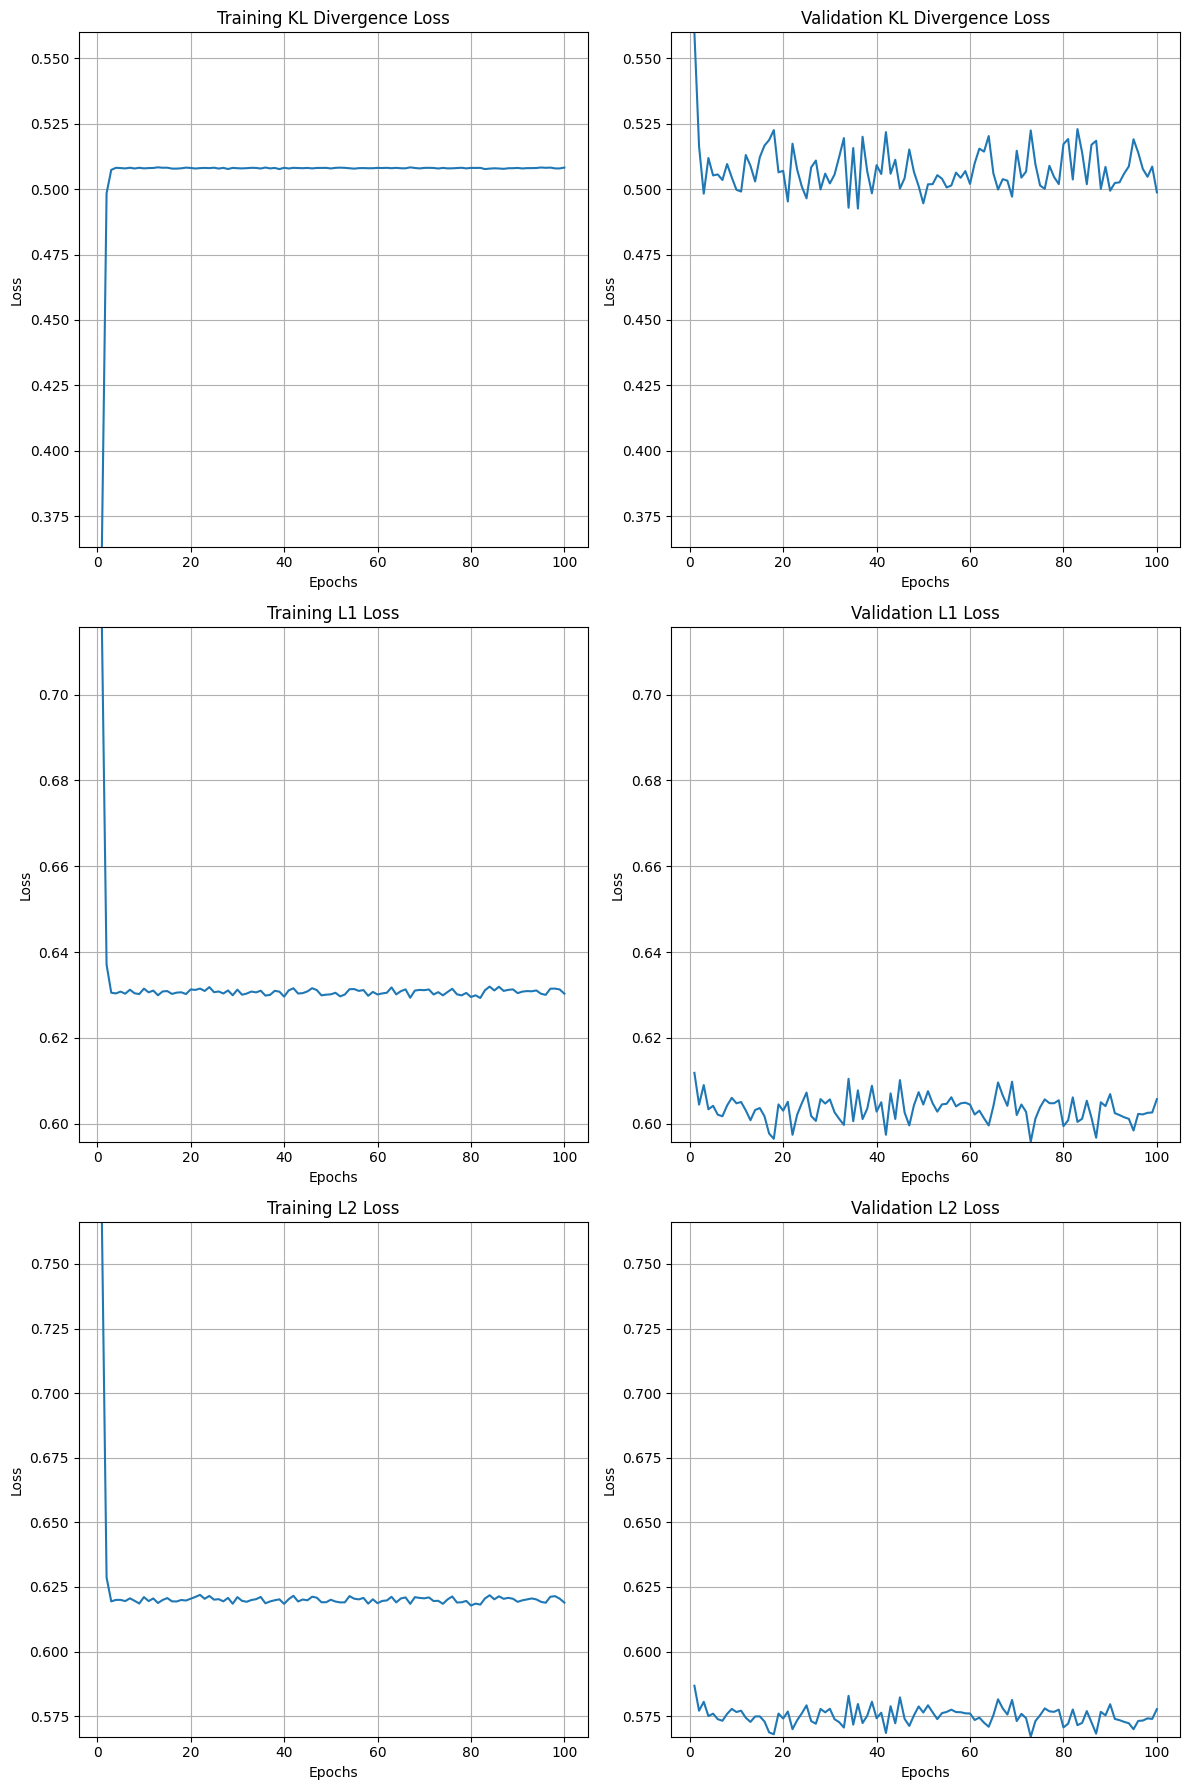

Best Validation Loss in Kelvins:
57.3671 K


In [7]:
# * * * * * * * * * * * * * * * *
# Train and Validate
# * * * * * * * * * * * * * * * *
losses = train(
	vae, train_loader, val_loader,
	optimizer, scheduler, DEVICE, EPOCHS,
	BETA, model_dir)

# Plot losses
PlotLosses(losses, EPOCHS, model_dir)

# Save losses
SaveLossesToCSV(losses, os.path.join(model_dir, "losses.csv"))

PrintAndLog(log_filepath, "Best Validation Loss in Kelvins:\n")
PrintAndLog(
	log_filepath,
	f"\t{min(losses['val_l1_losses'])*x_data_std:.4f} K\n")

In [8]:
# * * * * * * * * * * * * * * * *
# Sample
# * * * * * * * * * * * * * * * *
z_sample = SampleLatentSpace(
	vae,
	test_loader,
	scaler,
	DEVICE,
	model_dir
)

[Sampling]: 100%|██████████| 2/2 [00:10<00:00,  5.47s/it]


z0: 0.0715
z1: 0.0879
z2: 0.0334
z3: -0.0278


Traversing Latent Dimension z3: 100%|██████████| 11/11 [00:00<00:00, 664.62it/s]


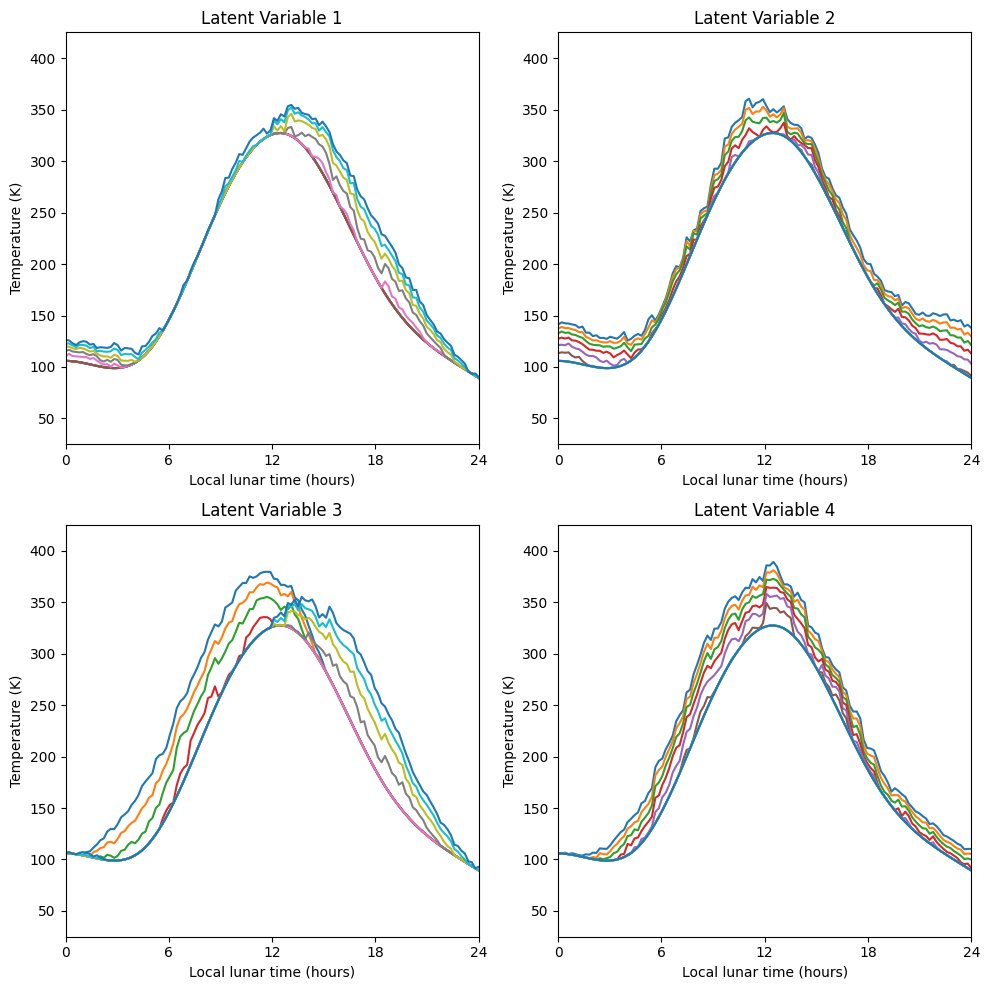

In [9]:
# * * * * * * * * * * * * * * * *
# Analyze Latent Space
# * * * * * * * * * * * * * * * *
mean_latent_vals = GetMeanLatentValues(z_sample, LATENT_DIM)
for i in range(LATENT_DIM):
	print(f"z{i}: {mean_latent_vals[i]:.4f}")

VisualizeLatentSpace(
	vae, LATENT_DIM, z_sample,
	scaler, DEVICE, model_dir)